In [1]:
function HPCA_POGM(Y, λr, w, N, ϵ)
    #objective = (X,Z,λr,Π) -> λr*nucnorm(X) + (1/2)*norm(Z*(Diagonal(Π.^-0.5)), 2)
    Π = w.^-1
    Lf = maximum(Π)
    Π = Diagonal(Π)
    x0 = zeros(size(Y))
    #U = svd(Y).U[:,1:N]
    #x0 = U*U'*Y
    grad = K -> -1*(Y-K)*Π
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    K, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=ϵ) # objective(x,Y-x,λr,w)
    return K
end
function AltMin(Y, λr, w, N, ϵ)
    Π = copy(w)
    U = svd(Y).U[:,1:N]
    #X = zeros(size(Y))
    X = U*U'*Y
    X0 = copy(X) .+ 1
    Π = W_ALL_GROUPS(Y, X)
    while norm(X-X0)/norm(X0) > ϵ
        X0 = X
        X = HPCA_POGM(Y, λr, Π, 0, ϵ)
        Π = W_ALL_GROUPS(Y, X)
    end
    return X, Π
end

AltMin (generic function with 1 method)

In [3]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 100
D = 100
d = 10
σ1 = 2
σ2 = 35
goodpts = 5
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    X[:,k] = U1*U1'*rand(Uniform(-100,100),D)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [79]:
function HPCA_UNKNOWN_ADMM(Y, λr, N, μ, ρ, d, U_init)
    #X = zeros(size(Y))
    #Z = zeros(size(X))
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    var = 0
    if (U_init == 0)
        #heppCAT_matrix = []
        #goodpts = 10
        #push!(heppCAT_matrix, Y[:,1:goodpts])
        #push!(heppCAT_matrix, Y[:,(goodpts+1):end])
        #var = heppcat(heppCAT_matrix,N,0).v[1]*vec(ones(size(Y)[2],1)) # homo pca
        var = vec(ones(100,1))
    else
        var = W_ALL_GROUPS(Y,X)
    end
    Π = diagm(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
    #for i = 1:1000
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        var = W_ALL_GROUPS(Y,X)
        Π = diagm(var.^-1)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end

function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    return Π
end

function W_ALL_GROUPS(Y, L)
    Π = vec(zeros(size(Y)[2],1))
    d = size(Y)[1]
    goodpts = 5
    N = 100
    Π[1:goodpts] .= (1/(d*goodpts))*norm(Y[:,1:goodpts]-L[:,1:goodpts],2)^2
    Π[(goodpts+1):end] .= (1/(d*(N-goodpts)))*norm(Y[:,(goodpts+1):end]-L[:,(goodpts+1):end],2)^2
    return Π
end

W_ALL_GROUPS (generic function with 1 method)

In [60]:
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
heppCAT = heppcat(heppCAT_matrix,d,1000;varfloor=1e-9)   # init is homoscedastic PPCA
heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
error_heppcat = norm(heppCAT.U*heppCAT.U' - U1*U1', 2)/norm(U1*U1', 2)
error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)
Π_homo = homoPCA.v[1]*vec(ones(100,1));

In [80]:
λr2 = vcat(0:0.05:1,1:1:5)
error_hpca_admm = zeros(size(λr2))
for i=1:length(λr2)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr2[i], 0, 0.01, 1.005, d, homoPCA.U)  
    error_hpca_admm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [140]:
λr = vcat(0:0.5:5)
error_hpca_homo = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 10, 0.01, 1.005, d, homoPCA.U)  
    error_hpca_homo[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


In [82]:
λr = vcat(0:0.5:5)
error_hpca_zero = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 10, 0.01, 1.005, d, 0)  
    error_hpca_zero[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11


In [94]:
# λr = vcat(0:0.1:1,1:0.5:10)
# error_hpca_pogm = zeros(size(λr))
# λr[1] = 0.001
# for i=1:length(λr)
#     println(i)
#     flush(stdout)
#     X_HPCA,_ = AltMin(Y, 4, Π_homo, 10, 1e-4)
#     U_HPCA = svd(X_HPCA).U[:,1:10]
#     error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
# end

In [9]:
colors = theme_palette(:auto).colors

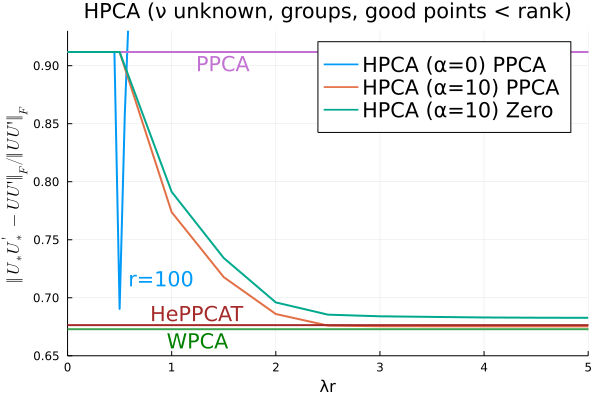

In [141]:
using LaTeXStrings
plot(λr2, error_hpca_admm, ylims=(0.65,0.93), label="HPCA (α=0) PPCA", title="HPCA (ν unknown, groups, good points < rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
plot!(λr, error_hpca_homo, xlims=(0,5), label="HPCA (α=10) PPCA", title="HPCA (ν unknown, groups, good points < rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2,c=colors[2])
hline!([error_wpca],label="", linewidth=2, c=colors[3])
hline!([error_homoppca],label="", linewidth=2, c=colors[4])
hline!([error_heppcat],label="", linewidth=2, c=:brown)
#plot!(λr, error_hpca_wpca, label="HPCA-10-WPCA",linewidth=2)
annotate!(1.25, error_wpca-0.01, "WPCA", :green)
annotate!(1.25, error_heppcat+0.01, "HePPCAT", :brown)
annotate!(1.5, error_homoppca-0.01, "PPCA", colors[4])
annotate!(0.9, error_heppcat+0.04, "r=100", colors[1])
plot!(λr, error_hpca_zero, label="HPCA (α=10) Zero", linewidth=2,c=colors[9])
#savefig("HPCA_UNKNOWN_BAD_GROUPS_CLOSEUP.pdf")

In [316]:
λr = vcat(0:0.5:10,20:10:50)
λr[1] = 0.001
error_hpca_rank10 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 10, 0.01, 1.005, 10, homoPCA.U)   #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank10[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [314]:
λr = vcat(0:0.5:10,20:10:50)
λr[1] = 0.001
error_hpca_rank8 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 8, 0.01, 1.005, 8, homoPCA.U)   #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank8[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [312]:
λr = vcat(0:0.5:10,20:10:50)
λr[1] = 0.001
error_hpca_rank12 = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 12, 0.01, 1.005, 12, homoPCA.U)   #HPCA_ADMM(Y, λr[i],Π, 10, 0.01, 1.0005,d) # 1.005
    error_hpca_rank12[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


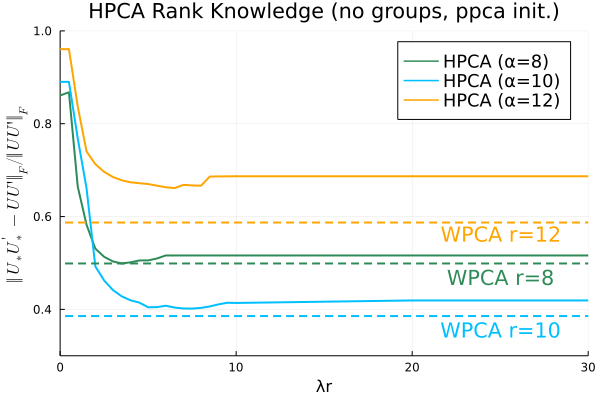

In [319]:
using LaTeXStrings
#plot(λr, error_rpca, label="HPCA (α=0)", title="HPCA Rank Knowledge (zero init.)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2)
plot(λr, error_hpca_rank8, xlims=(0,30),ylims=(0.3,1), label="HPCA (α=8)",linewidth=2, c=:seagreen, legend_title_font_pointsize=18)
plot!(λr, error_hpca_rank10, label="HPCA (α=10)",linewidth=2,title="HPCA Rank Knowledge (no groups, ppca init.)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",c=:deepskyblue)
plot!(λr, error_hpca_rank12, label="HPCA (α=12)",linewidth=2, c=:orange)
hline!([error_wpca_8], label="", linewidth=2, c=:seagreen,linestyle=:dash)
hline!([error_wpca_10], label="", c=:deepskyblue, linewidth=2,linestyle=:dash)
hline!([error_wpca_12], label="", linewidth=2, c=:orange,linestyle=:dash)
annotate!(25, error_wpca_10-0.03, "WPCA r=10", :deepskyblue)
annotate!(25, error_wpca_8-0.03, "WPCA r=8", :seagreen)
annotate!(25, error_wpca_12-0.025, "WPCA r=12", :orange)
#hline!([error_heppcat], label="HePPCAT",linewidth=2)
#savefig("HPCA_UNKNOWN_RANK_KNOWLEDGE_ZERO_INIT.pdf")

In [9]:
U_WPCA = weightedPCA(Y,Π.^-1,d)
error_wpca_10 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
U_WPCA = weightedPCA(Y,Π.^-1,8)
error_wpca_8 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)
U_WPCA = weightedPCA(Y,Π.^-1,12)
error_wpca_12 = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)

0.5871530004726269

In [25]:
X_NOG = HPCA_UNKNOWN_ADMM(Y, 40, 10, 0.01, 1.005, d, homoPCA.U)

100×10 Matrix{Float64}:
 -0.130223      0.0748345   -0.0635952  …  -0.00930212   0.039186
 -0.0817939    -0.0086571   -0.0115769      0.203113     0.058156
  0.0236994     0.187665     0.141352       0.057624     0.0559151
  0.12219       0.0852849   -0.0759383     -0.0281623    0.203871
 -0.0522266    -0.0494583   -0.071618       0.124915    -0.037985
  0.0414651     0.0357439    0.0335408  …  -0.162333     0.0662675
  0.0435969     0.069748    -0.0983993     -0.0127317    0.10703
  0.0803004    -0.136529     0.0300844      0.0627476    0.0824673
  0.0031741    -0.0105679   -0.034241       0.0384666    0.0655737
 -0.081444     -0.0928291   -0.0364332     -0.0510049    0.0247933
  0.137934      0.190481     0.160445   …  -0.0295569    0.113859
  0.0298238    -0.0518883   -0.0205605      0.179298     0.00992414
  0.0287193    -0.055786    -0.0805706      0.0884157   -0.0708649
  ⋮                                     ⋱               
  0.0672489     0.0793195    0.181068      -0.0409972 

In [27]:
X_G_R50 = HPCA_UNKNOWN_ADMM(Y, 50, 10, 0.01, 1.005, d, homoPCA.U)

100×10 Matrix{Float64}:
 -0.139014     0.039271    0.230711   -0.0304093   …  -0.0324793    0.0133479
 -0.0621262   -0.0358672   0.125623    0.0666455      -0.121188     0.0577222
 -0.0344275    0.179492    0.0179585   0.185041        0.00761611   0.0503986
  0.0688074    0.130882    0.023074   -0.143531       -0.0411516    0.185891
 -0.0498946   -0.114189    0.0833803   0.0520556      -0.0889108   -0.0407137
  0.0263009    0.0447029  -0.0404324  -0.019322    …   0.182188     0.0891448
 -0.00916167   0.0587313  -0.143175   -0.129394        0.00486972   0.132547
  0.139622    -0.0528549  -0.0183593  -0.0870247      -0.0832554    0.0698117
 -0.00531143  -0.0220839  -0.0935704  -0.050842       -0.0245971    0.0833547
 -0.0389074   -0.113705    0.0843507   0.032694        0.0705238    0.0221697
  0.0745827    0.249306    0.0259913   0.0975632   …   0.00954683   0.0917807
  0.0309018   -0.0535898  -0.155724   -0.0633458      -0.158133     0.0104933
  0.0259449   -0.0825288   0.0646763   0.0

In [28]:
X_G_R8 = HPCA_UNKNOWN_ADMM(Y, 8, 10, 0.01, 1.005, d, homoPCA.U)

100×10 Matrix{Float64}:
 -0.114904    -0.0914704   -0.0799484   …   0.000284437   0.0244647
 -0.0496235    0.00773613  -0.0580344       0.150686      0.0168561
  0.0342588   -0.16968      0.117571        0.0593731     0.0679395
  0.11973     -0.114964    -0.0485482       0.011646      0.200371
 -0.0675118    0.0600352   -0.0739064       0.121708     -0.042731
  0.0531006   -0.0432815   -0.0154355   …  -0.161249      0.0884745
  0.0508577   -0.0917643   -0.12236        -0.0262723     0.0915115
  0.0865616    0.120039     0.0355588       0.0400289     0.0431416
  0.00708722   0.00157496  -0.0557275       0.0276238     0.06125
 -0.0705362    0.0988081   -0.0511816      -0.0863234     0.00683858
  0.131956    -0.186423     0.17175     …   0.00762994    0.12748
  0.0313892    0.0363127   -0.0607397       0.168249     -0.00754021
  0.0295308    0.0646756   -0.096528        0.108744     -0.0541339
  ⋮                                     ⋱                
  0.0703456   -0.069169     0.179411  

In [36]:
Π_G_R50 =  W_ALL_GROUPS(Y,X_G_R50*X_G_R50'*Y)
Π_G_R8 =  W_ALL_GROUPS(Y,X_G_R8*X_G_R8'*Y)
Π_NOG =  W_NO_GROUPS(Y,X_NOG*X_NOG'*Y);

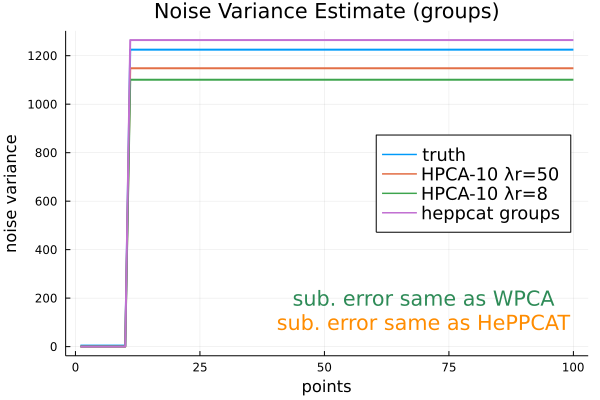

In [165]:
gr(legendfontsize=12)
heppcat_g = vcat(heppCAT.v[1]*ones(10,1), heppCAT.v[2]*ones(90,1))
plot(Π,label="truth",xlabel="points",ylabel="noise variance",title="Noise Variance Estimate (groups)", legend=:right,linewidth=2)
#plot!(Π_NOG, label="no groups")
plot!(Π_G_R50, label="HPCA-10 λr=50", linewidth=2)
plot!(Π_G_R8, labels="HPCA-10 λr=8",linewidth=2)
plot!(heppcat_g, labels="heppcat groups",linewidth=2)
annotate!(60, 400, "", :deepskyblue)
annotate!(70, 200, "sub. error same as WPCA", :seagreen)
annotate!(70, 100, "sub. error same as HePPCAT", :darkorange)
#savefig("variance_groups_part2.pdf")

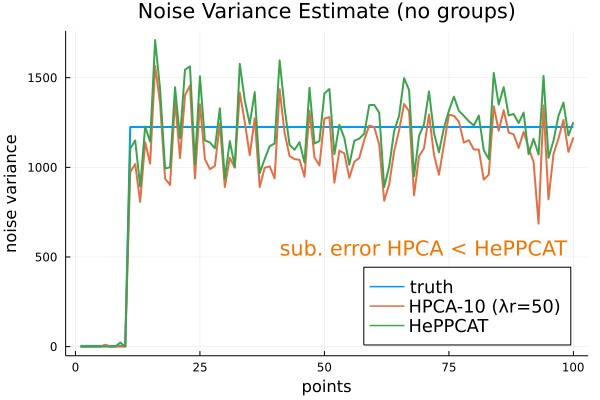

In [173]:
gr(legendfontsize=12)
heppcat_g = vcat(heppCAT.v[1]*ones(10,1), heppCAT.v[2]*ones(90,1))
plot(Π,label="truth",xlabel="points",ylabel="noise variance",title="Noise Variance Estimate (no groups)", legend=:bottomright,linewidth=2)
plot!(Π_NOG, label="HPCA-10 (λr=50)", linewidth=2)
plot!(heppCAT_NOG.v, labels="HePPCAT",linewidth=2)
# annotate!(75, 400, "truth", :deepskyblue)
# annotate!(75, 300, "error same as WPCA", :seagreen)
annotate!(70, 550, "sub. error HPCA < HePPCAT", :darkorange2)
#savefig("variance_no_groups_part2.pdf")

In [50]:
norm(X_G_R8*X_G_R8' - U1*U1', 2)/norm(U1*U1', 2)

0.38979009890052585

In [67]:
heppCAT.v[1]

1.4115650591353772e-14

In [148]:
norm(Π-Π_NOG)/norm(Π)

0.16334041408578517

In [150]:
norm(Π-heppCAT_NOG.v)/norm(Π)

0.1430793711299185

In [151]:
norm(Π-Π_G_R8)/norm(Π)

0.10142542336319714

In [152]:
norm(Π-heppcat_g)/norm(Π)

0.03228998631934483

In [187]:
 # David's SignFlip PA
σfs = [svdvals(rand([-1,1],size(Y)) .* X) for _ in 1:5]
σfs = [getindex.(σfs,j) for j in 1:min(D,N)]

α = 0.95
rhat = findfirst(svdvals(X) .<= quantile.(σfs,α)) - 1

10

In [132]:
zero(eltype(first(heppCAT_matrix)))

0.0